# Expressions

Esta tabla contiene la información a nivel de expression. --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt

from notebooks_utils import *
from domains import *

full_table = get_data('expressions')

# Table name, features and target.
TABLE_NAME = 'expressions'
TABLE_FEATURES = ['expression__category','expression__parent','expression__first_child_category','expression__second_child_category','expression__third_child_category','expression__fourth_child_category','expression__expression_role','expression__height','expression__depth','expression__expertise_level']
TABLE_TARGET = 'expression__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2024-05-29 23:21:49.378406 Data cache files found ...
2024-05-29 23:21:59.981608 Data cache files successfully loaded!!
Features shape: (8283007, 10)
Target shape: (8283007,)
As we can see the downloaded data contains a total of 8283007 instances. For each instance we have 10 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283007 entries, 0 to 8283006
Data columns (total 10 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   expression__category               object
 1   expression__parent                 object
 2   expression__first_child_category   object
 3   expression__second_child_category  object
 4   expression__third_child_category   object
 5   expression__fourth_child_category  object
 6   expression__expression_role        object
 7   expression__height                 int64 
 8   expression__depth                  int64 
 9   expression__expertise_level        object
dtypes: int64(2), object(8)
memory usage: 631.9+ MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 8283007 entries, 0 to 8283006
Series name: expression__expertise_level
Non-Null Count    Dtype 
--------------    ----- 
8283007 non-null  object
dtypes: object(1)
memory usage: 63.2+ MB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas y 8 de tipo objeto (cetegoricas). 

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 42.14% instances for BEGINNER class and 57.86% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [98.35%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

expression__category                       0
expression__parent                         0
expression__first_child_category     5317536
expression__second_child_category    6892615
expression__third_child_category     7870100
expression__fourth_child_category    8142133
expression__expression_role                0
expression__height                         0
expression__depth                          0
expression__expertise_level                0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [6]:
print_empty_cols(X)

expression__category
--------------------
0 instancias no tienen un valor para la columna expression__category


expression__parent
------------------
0 instancias no tienen un valor para la columna expression__parent


expression__first_child_category
--------------------------------
0 instancias no tienen un valor para la columna expression__first_child_category


expression__second_child_category
---------------------------------
0 instancias no tienen un valor para la columna expression__second_child_category


expression__third_child_category
--------------------------------
0 instancias no tienen un valor para la columna expression__third_child_category


expression__fourth_child_category
---------------------------------
0 instancias no tienen un valor para la columna expression__fourth_child_category


expression__expression_role
---------------------------
0 instancias no tienen un valor para la columna expression__expression_role


expression__height
------------------
0 inst

### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
expression__category,8283007,39,Variable,2862305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__parent,8283007,50,Call,1989841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__first_child_category,2965471,38,Variable,1488777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__second_child_category,1390392,36,Variable,463461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__third_child_category,412907,37,StringLiteral,125849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__fourth_child_category,140874,34,Variable,38472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__expression_role,8283007,79,CallArg,1129446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__height,8283007.0,NaN,NaN,NaN,5.210386,2.237697,1.0,4.0,5.0,6.0,83.0
expression__depth,8283007.0,NaN,NaN,NaN,0.605768,1.08675,0.0,0.0,0.0,1.0,81.0
expression__expertise_level,8283007,2,EXPERT,4792486,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias). Revisar programa con 3k modulos y 1k paquetes.

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "expression__height": [(1, 3), (3, 4), (4, 5), (5, 6) ,(6, 7), (7, inf)],  # min: 1 max: 83
    "expression__depth": [(0, 1), (1, 2), (2, inf)],  # min: 1 max: 81
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['expression__category'], 10))
print(get_statistics(X_copy, ['expression__parent'], 10))
print(get_statistics(X_copy, ['expression__first_child_category'], 10))
print(get_statistics(X_copy, ['expression__second_child_category'], 10))
print(get_statistics(X_copy, ['expression__third_child_category'], 10))
print(get_statistics(X_copy, ['expression__fourth_child_category'], 10))
print(get_statistics(X_copy, ['expression__expression_role'], 10))
print(get_statistics(X_copy, ['expression__height'], 10))
print(get_statistics(X_copy, ['expression__depth'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
print(get_statistics(X_copy, ['expression__category', 'expression__expression_role'], 10))
print(get_statistics(X_copy, ['expression__category', 'expression__parent'], 10))
print(get_statistics(X_copy, ['expression__parent', 'expression__expression_role'], 10))


# 3 FEATURES
print("--- THREE FEATURES ---")
print(get_statistics(X_copy, ['expression__category', 'expression__first_child_category', 'expression__second_child_category'], 10))


--- SINGLE FEATURE ---
expression__category   count  percentage
            Variable 2862305   34.556351
       StringLiteral 1087827   13.133238
          IntLiteral 1046248   12.631258
                 Dot  991125   11.965763
                Call  860395   10.387472
        TupleLiteral  234902    2.835951
            Indexing  176936    2.136132
             Compare  172486    2.082408
        FloatLiteral  150807    1.820679
     UnaryArithmetic  146763    1.771857

expression__parent   count  percentage
              Call 1989841   24.023172
               Dot  991125   11.965763
    AssignmentStmt  972800   11.744527
      TupleLiteral  886220   10.699255
 DictionaryLiteral  849429   10.255080
          Indexing  353872    4.272265
           Compare  346462    4.182805
                If  251205    3.032775
        Arithmetic  220102    2.657272
       ListLiteral  217235    2.622659

expression__first_child_category   count  percentage
                        Variable 1488777  

In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (8283007, 317)
Target shape: (8283007,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

In [10]:
# Con estos datos (8102385, 316) la matriz de confusion es demasiado grande.
# sns.heatmap(X.corr(), annot=True)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 9 variable (2 numericas y 7 categoricas) se hara un analisis detallado

### Variable category (1/9)
Esta variable es de tipo categorica y representa la categoria de la expresion.

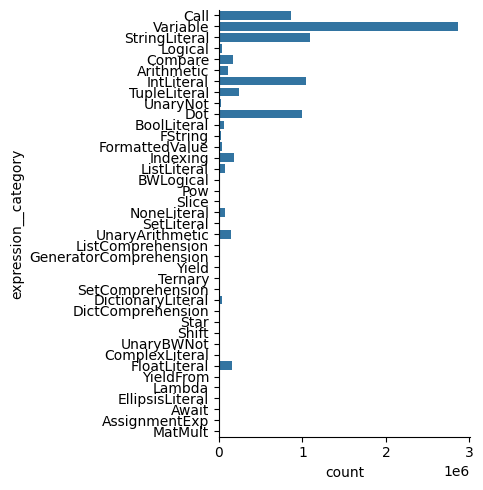

In [11]:
sns.catplot(full_table['expression__category'], kind="count")

In [12]:
print_frequency_anal_for_cat_var(full_table, 'expression__category')

La variable expression__category contiene 39 valores distintos.
El umbral de outlier es de 0.005128205128205128%
La variable expression__category toma el valor de Variable en un 34.56% de los items.
La variable expression__category toma el valor de StringLiteral en un 13.13% de los items.
La variable expression__category toma el valor de IntLiteral en un 12.63% de los items.
La variable expression__category toma el valor de Dot en un 11.97% de los items.
La variable expression__category toma el valor de Call en un 10.39% de los items.
La variable expression__category toma el valor de TupleLiteral en un 2.836% de los items.
La variable expression__category toma el valor de Indexing en un 2.136% de los items.
La variable expression__category toma el valor de Compare en un 2.082% de los items.
La variable expression__category toma el valor de FloatLiteral en un 1.821% de los items.
La variable expression__category toma el valor de UnaryArithmetic en un 1.772% de los items.
La variable exp

In [13]:
print_values_usage_for_cat_var(full_table, 'expression__category', EXPRESSION_CATEGORY_VALUES)

La variable expression__category puede tomar 39 valores distintos
	39 (100.0%) valores utilizados
	0 (0.0%) valores NO utilizados


### Variable parent (2/9)
Esta variable es de tipo categorica y representa la categoria del padre de la expresion.

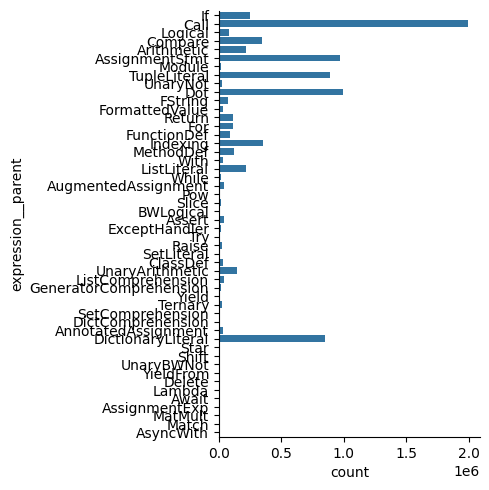

In [14]:
sns.catplot(full_table['expression__parent'], kind="count")

In [15]:
print_frequency_anal_for_cat_var(full_table, 'expression__parent')

La variable expression__parent contiene 50 valores distintos.
El umbral de outlier es de 0.004%
La variable expression__parent toma el valor de Call en un 24.02% de los items.
La variable expression__parent toma el valor de Dot en un 11.97% de los items.
La variable expression__parent toma el valor de AssignmentStmt en un 11.74% de los items.
La variable expression__parent toma el valor de TupleLiteral en un 10.7% de los items.
La variable expression__parent toma el valor de DictionaryLiteral en un 10.26% de los items.
La variable expression__parent toma el valor de Indexing en un 4.272% de los items.
La variable expression__parent toma el valor de Compare en un 4.183% de los items.
La variable expression__parent toma el valor de If en un 3.033% de los items.
La variable expression__parent toma el valor de Arithmetic en un 2.657% de los items.
La variable expression__parent toma el valor de ListLiteral en un 2.623% de los items.
La variable expression__parent toma el valor de UnaryArit

In [16]:
print_values_usage_for_cat_var(full_table, 'expression__parent', EXPRESSION_PARENT_VALUES)

La variable expression__parent puede tomar 66 valores distintos
	50 (75.76%) valores utilizados
	16 (24.24%) valores NO utilizados
		La variable expression__parent nunca toma valor Pass.
		La variable expression__parent nunca toma valor Import.
		La variable expression__parent nunca toma valor FloatLiteral.
		La variable expression__parent nunca toma valor TypeAlias.
		La variable expression__parent nunca toma valor Nonlocal.
		La variable expression__parent nunca toma valor IntLiteral.
		La variable expression__parent nunca toma valor Variable.
		La variable expression__parent nunca toma valor Continue.
		La variable expression__parent nunca toma valor Global.
		La variable expression__parent nunca toma valor StringLiteral.
		La variable expression__parent nunca toma valor BoolLiteral.
		La variable expression__parent nunca toma valor NoneLiteral.
		La variable expression__parent nunca toma valor ImportFrom.
		La variable expression__parent nunca toma valor ComplexLiteral.
		La variab

### Variable first_child_category (3/9)
Esta variable es de tipo categorica y representa la categoria del primer hijo de la expresion.

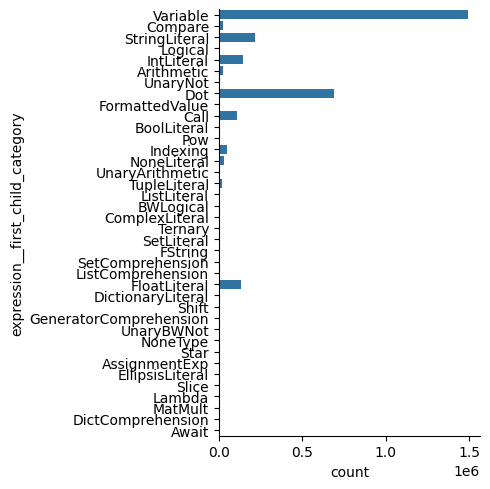

In [17]:
sns.catplot(full_table['expression__first_child_category'], kind="count")

In [18]:
print_frequency_anal_for_cat_var(full_table, 'expression__first_child_category')

La variable expression__first_child_category contiene 39 valores distintos.
El umbral de outlier es de 0.005128205128205128%
La variable expression__first_child_category toma el valor de None en un 64.2% de los items.
La variable expression__first_child_category toma el valor de Variable en un 17.97% de los items.
La variable expression__first_child_category toma el valor de Dot en un 8.336% de los items.
La variable expression__first_child_category toma el valor de StringLiteral en un 2.576% de los items.
La variable expression__first_child_category toma el valor de IntLiteral en un 1.766% de los items.
La variable expression__first_child_category toma el valor de FloatLiteral en un 1.629% de los items.
La variable expression__first_child_category toma el valor de Call en un 1.289% de los items.
La variable expression__first_child_category toma el valor de Indexing en un 0.583% de los items.
La variable expression__first_child_category toma el valor de NoneLiteral en un 0.355% de los 

In [19]:
print_values_usage_for_cat_var(full_table, 'expression__first_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__first_child_category puede tomar 41 valores distintos
	39 (95.12%) valores utilizados
	3 (7.317%) valores NO utilizados
		La variable expression__first_child_category nunca toma valor Parameter.
		La variable expression__first_child_category nunca toma valor YieldFrom.
		La variable expression__first_child_category nunca toma valor Yield.
La variable expression__first_child_category toma 1 valores desconocidos
		La variable expression__first_child_category toma valor el desconocido NoneType.


### Variable second_child_category (4/9)
Esta variable es de tipo categorica y representa la categoria del segundo hijo de la expresion.

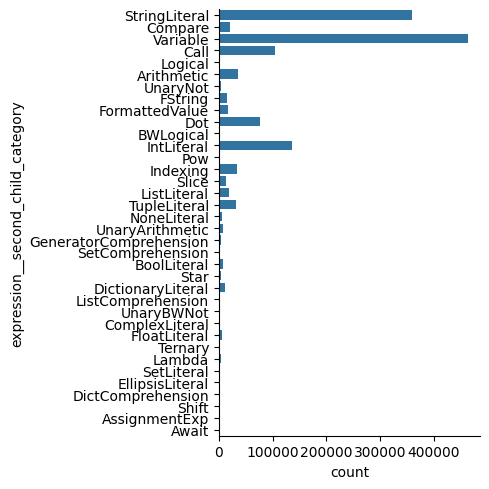

In [20]:
sns.catplot(full_table['expression__second_child_category'], kind="count")

In [21]:
print_frequency_anal_for_cat_var(full_table, 'expression__second_child_category')

La variable expression__second_child_category contiene 37 valores distintos.
El umbral de outlier es de 0.005405405405405406%
La variable expression__second_child_category toma el valor de None en un 83.21% de los items.
La variable expression__second_child_category toma el valor de Variable en un 5.595% de los items.
La variable expression__second_child_category toma el valor de StringLiteral en un 4.345% de los items.
La variable expression__second_child_category toma el valor de IntLiteral en un 1.642% de los items.
La variable expression__second_child_category toma el valor de Call en un 1.258% de los items.
La variable expression__second_child_category toma el valor de Dot en un 0.9241% de los items.
La variable expression__second_child_category toma el valor de Arithmetic en un 0.4355% de los items.
La variable expression__second_child_category toma el valor de Indexing en un 0.4113% de los items.
La variable expression__second_child_category toma el valor de TupleLiteral en un 0

In [22]:
print_values_usage_for_cat_var(full_table, 'expression__second_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__second_child_category puede tomar 41 valores distintos
	37 (90.24%) valores utilizados
	4 (9.756%) valores NO utilizados
		La variable expression__second_child_category nunca toma valor Parameter.
		La variable expression__second_child_category nunca toma valor YieldFrom.
		La variable expression__second_child_category nunca toma valor MatMult.
		La variable expression__second_child_category nunca toma valor Yield.


### Variable third_child_category (5/9)
Esta variable es de tipo categorica y representa la categoria del tercer hijo de la expresion.

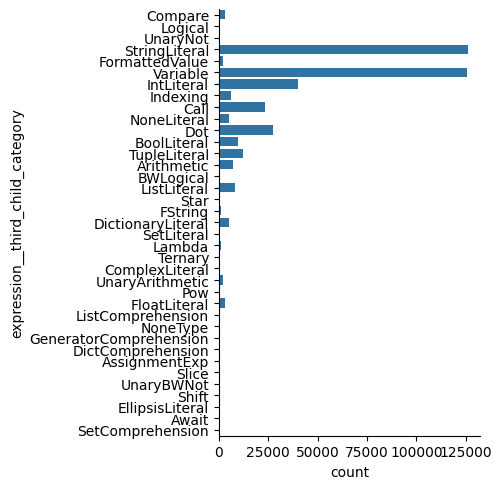

In [23]:
sns.catplot(full_table['expression__third_child_category'], kind="count")

In [24]:
print_frequency_anal_for_cat_var(full_table, 'expression__third_child_category')

La variable expression__third_child_category contiene 38 valores distintos.
El umbral de outlier es de 0.005263157894736842%
La variable expression__third_child_category toma el valor de None en un 95.02% de los items.
La variable expression__third_child_category toma el valor de StringLiteral en un 1.519% de los items.
La variable expression__third_child_category toma el valor de Variable en un 1.517% de los items.
La variable expression__third_child_category toma el valor de IntLiteral en un 0.4845% de los items.
La variable expression__third_child_category toma el valor de Dot en un 0.3327% de los items.
La variable expression__third_child_category toma el valor de Call en un 0.2835% de los items.
La variable expression__third_child_category toma el valor de TupleLiteral en un 0.1476% de los items.
La variable expression__third_child_category toma el valor de BoolLiteral en un 0.1181% de los items.
La variable expression__third_child_category toma el valor de ListLiteral en un 0.097

In [25]:
print_values_usage_for_cat_var(full_table, 'expression__third_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__third_child_category puede tomar 41 valores distintos
	38 (92.68%) valores utilizados
	4 (9.756%) valores NO utilizados
		La variable expression__third_child_category nunca toma valor Parameter.
		La variable expression__third_child_category nunca toma valor YieldFrom.
		La variable expression__third_child_category nunca toma valor MatMult.
		La variable expression__third_child_category nunca toma valor Yield.
La variable expression__third_child_category toma 1 valores desconocidos
		La variable expression__third_child_category toma valor el desconocido NoneType.


### Variable fourth_child_category (6/9)
Esta variable es de tipo categorica y representa la categoria del cuarto hijo de la expresion.

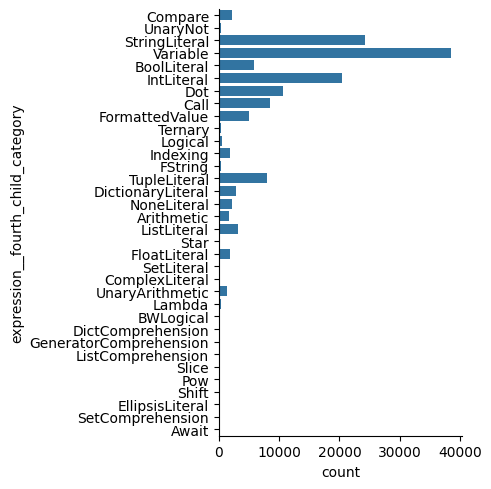

In [26]:
sns.catplot(full_table['expression__fourth_child_category'], kind="count")

In [27]:
print_frequency_anal_for_cat_var(full_table, 'expression__fourth_child_category')

La variable expression__fourth_child_category contiene 35 valores distintos.
El umbral de outlier es de 0.005714285714285714%
La variable expression__fourth_child_category toma el valor de None en un 98.3% de los items.
La variable expression__fourth_child_category toma el valor de Variable en un 0.4645% de los items.
La variable expression__fourth_child_category toma el valor de StringLiteral en un 0.2929% de los items.
La variable expression__fourth_child_category toma el valor de IntLiteral en un 0.2473% de los items.
La variable expression__fourth_child_category toma el valor de Dot en un 0.129% de los items.
La variable expression__fourth_child_category toma el valor de Call en un 0.1032% de los items.
La variable expression__fourth_child_category toma el valor de TupleLiteral en un 0.09649% de los items.
La variable expression__fourth_child_category toma el valor de BoolLiteral en un 0.06946% de los items.
La variable expression__fourth_child_category toma el valor de FormattedVa

In [28]:
print_values_usage_for_cat_var(full_table, 'expression__fourth_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__fourth_child_category puede tomar 41 valores distintos
	35 (85.37%) valores utilizados
	6 (14.63%) valores NO utilizados
		La variable expression__fourth_child_category nunca toma valor Parameter.
		La variable expression__fourth_child_category nunca toma valor Yield.
		La variable expression__fourth_child_category nunca toma valor AssignmentExp.
		La variable expression__fourth_child_category nunca toma valor UnaryBWNot.
		La variable expression__fourth_child_category nunca toma valor MatMult.
		La variable expression__fourth_child_category nunca toma valor YieldFrom.


### Variable expression_role (7/9)
Esta variable es de tipo categorica y representa el rol de la expresion en su padre.

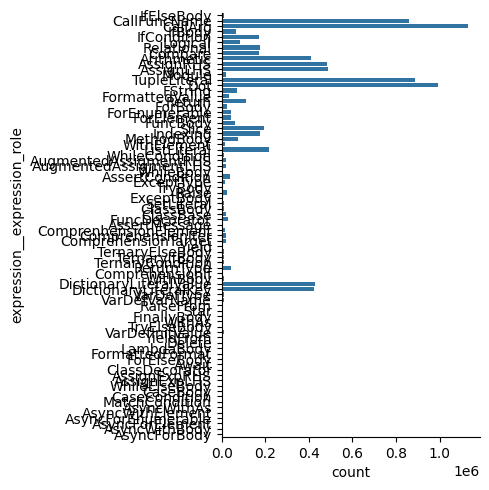

In [29]:
sns.catplot(full_table['expression__expression_role'], kind="count")

In [30]:
print_frequency_anal_for_cat_var(full_table, 'expression__expression_role')

La variable expression__expression_role contiene 79 valores distintos.
El umbral de outlier es de 0.002531645569620253%
La variable expression__expression_role toma el valor de CallArg en un 13.64% de los items.
La variable expression__expression_role toma el valor de Dot en un 11.97% de los items.
La variable expression__expression_role toma el valor de TupleLiteral en un 10.7% de los items.
La variable expression__expression_role toma el valor de CallFuncName en un 10.39% de los items.
La variable expression__expression_role toma el valor de AssignLHS en un 5.881% de los items.
La variable expression__expression_role toma el valor de AssignRHS en un 5.864% de los items.
La variable expression__expression_role toma el valor de DictionaryLiteralValue en un 5.15% de los items.
La variable expression__expression_role toma el valor de DictionaryLiteralKey en un 5.141% de los items.
La variable expression__expression_role toma el valor de Arithmetic en un 4.951% de los items.
La variable e

In [31]:
print_values_usage_for_cat_var(full_table, 'expression__expression_role', EXPRESSION_ROLE_VALUES)

La variable expression__expression_role puede tomar 89 valores distintos
	79 (88.76%) valores utilizados
	17 (19.1%) valores NO utilizados
		La variable expression__expression_role nunca toma valor AugmentedAssignmentLHS.
		La variable expression__expression_role nunca toma valor TypeAliasLHS.
		La variable expression__expression_role nunca toma valor In.
		La variable expression__expression_role nunca toma valor Pow.
		La variable expression__expression_role nunca toma valor BWLogical.
		La variable expression__expression_role nunca toma valor AsyncForElseBody.
		La variable expression__expression_role nunca toma valor Is.
		La variable expression__expression_role nunca toma valor TryElse.
		La variable expression__expression_role nunca toma valor MatMult.
		La variable expression__expression_role nunca toma valor TypeAliasRHS.
		La variable expression__expression_role nunca toma valor TypeAnnotation.
		La variable expression__expression_role nunca toma valor DefaultParamValue.
		La v

### Variable height (8/9)
Esta variable representa la distancia de la expresión al root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 83. Con una media de 5.21.

<Axes: ylabel='expression__height'>

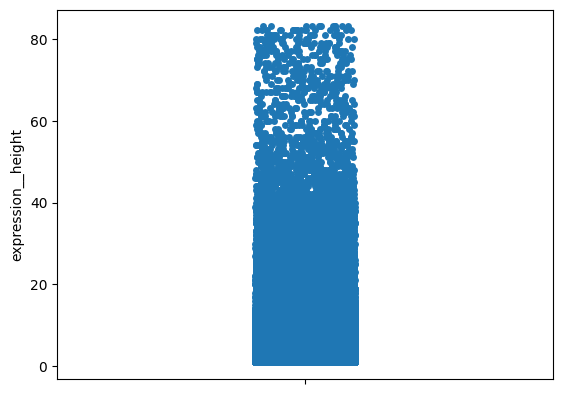

In [32]:
sns.stripplot(X['expression__height'])

In [33]:
print_outliers_for_df_column(X, 'expression__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8447416003157453
Rango valores atípicos extremos (Tukey): [-2.0,12.0]
Rango valores atípicos leves (Tukey): [1.0,9.0]
Rango valores atípicos extremos (Fixed BoxPlot): [3.844013109799,94.02128761422571]
-3.0IQR: 0 instancias tienen un valor para expression__height inferior a -2.0 (Q1-3*IQR) para expression__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para expression__height inferior a 1.0 (Q1-1.5*IQR) para expression__height. Representando un 0.0% del total de instancias.
+1.5IQR: 278290 instancias tienen un valor para expression__height superior a 9.0 (Q3+1.5*IQR) para expression__height. Representando un 3.36% del total de instancias.
+3.0IQR: 58811 instancias tienen un valor para expression__height superior a 12.0 (Q3-3*IQR) para expression__height. Representando un 0.71% del total de instancias.
L: 1365957 instancias tienen un valor para expression__height inferior a 3.844013

In [34]:
X[X['expression__height'] > 12].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,expression__height,expression__depth,expression__category_Arithmetic,expression__category_AssignmentExp,expression__category_Await,expression__category_BWLogical,expression__category_BoolLiteral,expression__category_Call,expression__category_Compare,expression__category_ComplexLiteral,...,expression__expression_role_WhileBody,expression__expression_role_WhileCondition,expression__expression_role_WhileElseBody,expression__expression_role_WithAs,expression__expression_role_WithBody,expression__expression_role_WithElement,expression__expression_role_Yield,expression__expression_role_YieldFrom,expression__expertise_level_BEGINNER,expression__expertise_level_EXPERT
count,58811.000000,58811.000000,58811.000000,58811.000000,58811.0,58811.000000,58811.000000,58811.000000,58811.000000,58811.000000,...,58811.000000,58811.000000,58811.0,58811.0,58811.000000,58811.000000,58811.000000,58811.0,58811.000000,58811.000000
mean,17.874752,0.822312,0.038003,0.000017,0.0,0.001972,0.005407,0.087008,0.032035,0.000340,...,0.000051,0.000221,0.0,0.0,0.000017,0.000051,0.000204,0.0,0.538284,0.461716
std,8.432153,3.560059,0.191205,0.004124,0.0,0.044368,0.073335,0.281848,0.176094,0.018438,...,0.007142,0.014866,0.0,0.0,0.004124,0.007142,0.014283,0.0,0.498536,0.498536
min,13.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,13.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,15.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
75%,18.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,83.000000,70.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


### Variable depth (9/9)
Esta variable representa la distancia desde la expresion hasta una hoja del ast. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 81. Con una media de 0.60.

<Axes: ylabel='expression__depth'>

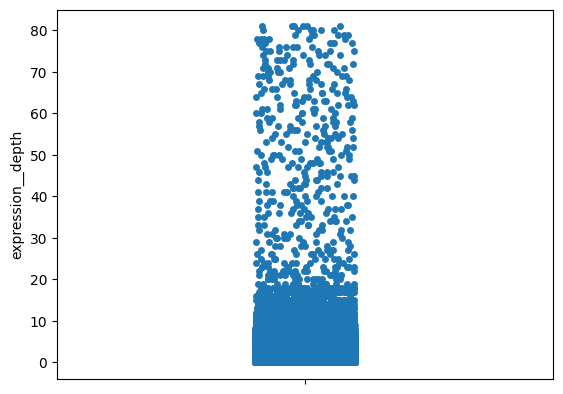

In [35]:
sns.stripplot(X['expression__depth'])

In [36]:
print_outliers_for_df_column(X, 'expression__depth')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.5802680522295767
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.19681854330434462,16.27988590906806]
-3.0IQR: 0 instancias tienen un valor para expression__depth inferior a -3.0 (Q1-3*IQR) para expression__depth. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para expression__depth inferior a -1.5 (Q1-1.5*IQR) para expression__depth. Representando un 0.0% del total de instancias.
+1.5IQR: 488863 instancias tienen un valor para expression__depth superior a 2.5 (Q3+1.5*IQR) para expression__depth. Representando un 5.902% del total de instancias.
+3.0IQR: 69810 instancias tienen un valor para expression__depth superior a 4.0 (Q3-3*IQR) para expression__depth. Representando un 0.8428% del total de instancias.
L: 0 instancias tienen un valor para expression__depth inferior a -0.19681854330

In [37]:
X[X['expression__depth'] > 4].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,expression__height,expression__depth,expression__category_Arithmetic,expression__category_AssignmentExp,expression__category_Await,expression__category_BWLogical,expression__category_BoolLiteral,expression__category_Call,expression__category_Compare,expression__category_ComplexLiteral,...,expression__expression_role_WhileBody,expression__expression_role_WhileCondition,expression__expression_role_WhileElseBody,expression__expression_role_WithAs,expression__expression_role_WithBody,expression__expression_role_WithElement,expression__expression_role_Yield,expression__expression_role_YieldFrom,expression__expertise_level_BEGINNER,expression__expertise_level_EXPERT
count,69810.000000,69810.000000,69810.000000,69810.000000,69810.000000,69810.000000,69810.0,69810.000000,69810.000000,69810.0,...,69810.000000,69810.000000,69810.000000,69810.0,69810.000000,69810.000000,69810.000000,69810.0,69810.000000,69810.000000
mean,5.121587,6.006489,0.113336,0.000014,0.005916,0.008265,0.0,0.484300,0.066480,0.0,...,0.001991,0.004240,0.000014,0.0,0.006475,0.001361,0.001261,0.0,0.305730,0.694270
std,4.015277,3.794530,0.317006,0.003785,0.076689,0.090538,0.0,0.499757,0.249122,0.0,...,0.044578,0.064978,0.003785,0.0,0.080205,0.036865,0.035482,0.0,0.460719,0.460719
min,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
75%,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,78.000000,81.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


## Multivariate

TODO: isolation forest algorithm

In [38]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,expression__expression_id,expression__category,expression__parent,expression__first_child_category,expression__second_child_category,expression__third_child_category,expression__fourth_child_category,expression__expression_role,expression__height,expression__depth,expression__expertise_level
3934,4265,Logical,If,Compare,StringLiteral,StringLiteral,None,IfCondition,2,2,BEGINNER
7125,7905,ListLiteral,Call,IntLiteral,IntLiteral,IntLiteral,IntLiteral,CallArg,2,1,BEGINNER
7134,7895,ListLiteral,Call,IntLiteral,IntLiteral,IntLiteral,IntLiteral,CallArg,2,1,BEGINNER
14302,484680,DictionaryLiteral,Call,StringLiteral,IntLiteral,StringLiteral,BoolLiteral,CallArg,3,4,BEGINNER
14438,484670,ListLiteral,Arithmetic,StringLiteral,StringLiteral,StringLiteral,None,Arithmetic,4,1,BEGINNER
...,...,...,...,...,...,...,...,...,...,...,...
8281170,9209200,ListLiteral,Return,StringLiteral,StringLiteral,StringLiteral,StringLiteral,Return,4,1,EXPERT
8281216,9209127,ListLiteral,Return,StringLiteral,StringLiteral,StringLiteral,StringLiteral,Return,4,1,EXPERT
8281535,9208727,ListLiteral,Return,StringLiteral,StringLiteral,StringLiteral,Variable,Return,4,1,EXPERT
8281584,9208669,ListLiteral,Return,StringLiteral,StringLiteral,StringLiteral,StringLiteral,Return,4,1,EXPERT
